In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

2023-07-06 03:38:26.955298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from xy import *

J = 1
max_t = 0.5
min_t = 0.5
lattice_shape = (8,8) #It can be  changed to (16,16) or (32,32)
steps = 1
iters_per_step = 31 #to remove autocorrelation among each of the 32 lattice sites
random_state = 50
t_vals = np.linspace(min_t, max_t, 1)
print(t_vals)

# betas = 1 / T_vals
lattices = []
#Monte Carlo Simulation
for beta in t_vals:
        lat=[]
        print(beta)
        random_state=random_state+1
        xy=XYModelMetropolisSimulation(lattice_shape=lattice_shape,
                                       beta=1/beta,J=J,random_state=random_state)
        for q in range(40000):
            xy.simulate(steps,iters_per_step)
            lat.append(xy.L+0)
            # draw_grid(lattice_shape[0],xy.L,1/beta)
        lattices.append(lat[30000:])  #initial 30000 rejected and last 10000 accepted
        print('Done')

[0.5]
0.5
Done


In [3]:
n = np.random.randint(low = 0, high = 10000)
start_lattice = lattices[0][n]
print(start_lattice)

[[0.45121203 0.35517992 0.32157192 0.39625863 0.36140468 0.29493396
  0.40073964 0.42119009]
 [0.49629827 0.26882994 0.30222129 0.2736027  0.36481113 0.26823661
  0.39357289 0.46357644]
 [0.37654952 0.53065609 0.3134225  0.34155855 0.34994298 0.31162467
  0.40048344 0.43282279]
 [0.26832664 0.37105517 0.50456552 0.38357158 0.41722123 0.35036717
  0.45429806 0.51669959]
 [0.3680475  0.41672437 0.48484838 0.30142931 0.3695239  0.44281077
  0.43448699 0.39479544]
 [0.37101712 0.53968434 0.50906656 0.30733481 0.30590429 0.32762109
  0.3788674  0.42307294]
 [0.27357633 0.42013522 0.46682592 0.24756357 0.3865362  0.31387942
  0.36373676 0.41602072]
 [0.51784097 0.38763864 0.31406047 0.39028053 0.32815037 0.24362903
  0.45460284 0.53656446]]


In [4]:
def cond_p_theta(theta,theta_not,temp,lambda1):
    return np.exp(np.cos(theta - theta_not)*(lambda1/temp))

In [5]:
def sample_cond_theta(theta1,theta2,theta3,theta4,temp,no_samples):
    sin_sum  = np.sin(theta1) + np.sin(theta2) + np.sin(theta3) + np.sin(theta4)
    cos_sum  = np.cos(theta1) + np.cos(theta2) + np.cos(theta3) + np.cos(theta4)
    
    lambda1  = np.sqrt(sin_sum**2 + cos_sum**2)
    theta_not= np.arctan2(sin_sum,cos_sum)
    theta_x  = np.linspace(0,2*np.pi,361)
    pdf_x    = cond_p_theta(theta_x,theta_not,temp,lambda1)
    pdf_x    = pdf_x/np.sum(pdf_x[:360])
    prob_bin = pdf_x[:360]
    samples_array = []
    for i in range(no_samples):
        z = np.random.multinomial(1,prob_bin)
        k = np.argmax(z)
        lower_limit_bin = k*(2*np.pi/360)
        upper_limit_bin = (k+1)*(2*np.pi/360)
        sample = np.random.uniform(lower_limit_bin,upper_limit_bin)
        samples_array.append(sample)
    samples_array = np.array(samples_array)
    return samples_array

In [6]:
T = 0.5

def generate_cond_data(pos, no_samples):
    i,j = pos
    #find neighbourhood theta values
    theta1 = start_lattice[i, (j + 1) % start_lattice.shape[1]]
    theta2 = start_lattice[i, (j - 1) % start_lattice.shape[1]]
    theta3 = start_lattice[(i + 1) % start_lattice.shape[0], j]
    theta4 = start_lattice[(i - 1) % start_lattice.shape[0], j]
    theta0_samples = sample_cond_theta(theta1, theta2, theta3, theta4, T, no_samples) #samples theta0 by fixing nghbr thetas
    theta0_samples = np.divide(theta0_samples,2*np.pi)
    #stack conditional data in 5x1 vector
    stacked_data = np.array([[theta0_samples[i],theta1, theta2,theta3,theta4] for i in range(len(theta0_samples))])
    return stacked_data

In [7]:
dataset = []
for i in range(start_lattice.shape[0]):
    for j in range(start_lattice.shape[1]):
        stack = generate_cond_data((i,j),1000)
        dataset.append(stack)

#for each (i,j) in start_lattice, generate 1000 conditional thetas
dataset = np.array(dataset)
print(dataset.shape)

(64, 1000, 5)


In [8]:
#Saving Data
output = open('conditional_data.pkl', 'wb')
pickle.dump(dataset, output)
output.close()

In [16]:
# sample generation
theta1 = 0.
theta2 = 0.
theta3 = 0.
theta4 = 0.
T = 2.05

samples = sample_cond_theta(theta1,theta2,theta3,theta4,T,10000)


(array([315., 309., 283., 298., 315., 291., 278., 258., 218., 212., 231.,
        203., 189., 158., 146., 128., 144., 105., 100.,  98.,  83.,  86.,
         77.,  61.,  50.,  38.,  41.,  35.,  18.,  22.,  23.,  14.,  16.,
         13.,  14.,   4.,  14.,  15.,  11.,  10.,  10.,   7.,   9.,  14.,
          5.,   5.,   7.,  10.,   2.,   8.,   8.,   8.,   9.,   5.,  10.,
          9.,   4.,   6.,   6.,   8.,  11.,   8.,  10.,  11.,  12.,  21.,
         14.,  20.,  15.,  18.,  22.,  32.,  32.,  42.,  51.,  66.,  66.,
         51.,  64.,  85.,  86., 114., 112., 122., 135., 151., 167., 193.,
        193., 190., 221., 251., 261., 270., 268., 318., 288., 287., 307.,
        341.]),
 array([4.61830073e-05, 6.28768245e-02, 1.25707466e-01, 1.88538107e-01,
        2.51368749e-01, 3.14199390e-01, 3.77030032e-01, 4.39860673e-01,
        5.02691315e-01, 5.65521956e-01, 6.28352597e-01, 6.91183239e-01,
        7.54013880e-01, 8.16844522e-01, 8.79675163e-01, 9.42505805e-01,
        1.00533645e+00, 1.0681

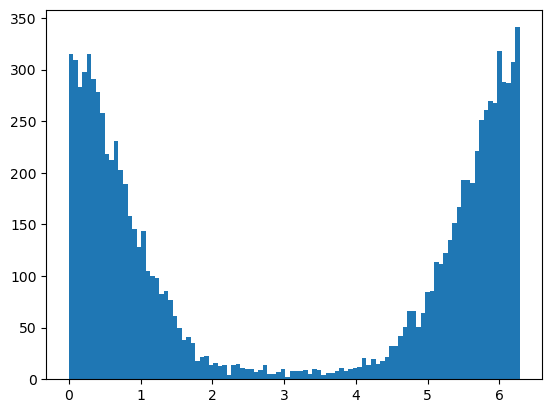

In [17]:
plt.hist(samples,bins=100)

In [ ]:
x_data